<a href="https://colab.research.google.com/github/luanaapms/analytics-td/blob/main/api_medallion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API MEDALLION

## Configurações de Ambiente

In [ ]:
!pip install pandas matplotlib seaborn requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
from datetime import datetime

In [ ]:
!pip install requests_cache openmeteo-requests
import requests_cache
import openmeteo_requests

## API

In [ ]:
# sessão em cache
sessao_cache = requests_cache.CachedSession('.cache', expire_after=3600)
cliente = openmeteo_requests.Client(session=sessao_cache)

In [ ]:
url = "https://archive-api.open-meteo.com/v1/archive"

# parâmetros da API
def montar_parametros(lat, lon):
    return {
        "latitude": lat,
        "longitude": lon,
        "hourly": [
            "temperature_2m",
            "soil_temperature_0_to_7cm",
            "relative_humidity_2m",
            "rain",
        ],
        "start_date": "2010-01-01",
        "end_date": "2023-12-31"
    }

In [ ]:
# escolhendo as 10 cidades
cidades = {
    "Nova York, EUA": (40.7128, -74.0060),
    "Londres, Reino Unido": (51.5074, -0.1278),
    "Tóquio, Japão": (35.6895, 139.6917),
    "Sydney, Austrália": (-33.8688, 151.2093),
    "Cidade do Cabo, África do Sul": (-33.9249, 18.4241),
    "Cairo, Egito": (30.0444, 31.2357),
    "Cidade do México, México": (19.4326, -99.1332),
    "São Paulo, Brasil": (-23.5505, -46.6333),
    "Moscou, Rússia": (55.7558, 37.6173),
    "Mumbai, Índia": (19.0760, 72.8777)
}

## Camada Bronze

Dados Brutos e Não Modificados: dados são armazenados exatamente como foram recebidos da origem, mantendo o formato original.

In [ ]:
# nota: rodar o script mais uma vez caso exceder limite de tempo da api
bronze_lista = []

# loop para iterar sobre cada cidade com suas coordenadas latitude e longitude
for cidade, (lat, lon) in cidades.items():
    print(f"Coletando dados para {cidade}...")
    parametros = montar_parametros(lat, lon)

    try:
        resposta = cliente.weather_api(url, params=parametros)[0]
        dados_horarios = resposta.Hourly()

        datas = pd.date_range(
            start=pd.to_datetime(dados_horarios.Time(), unit="s", utc=True),
            end=pd.to_datetime(dados_horarios.TimeEnd(), unit="s", utc=True),
            freq=pd.Timedelta(seconds=dados_horarios.Interval()),
            inclusive="left"
        )

        # criando um df com as colunas de interesse e informações da cidade
        df_cidade = pd.DataFrame({
            "datetime_utc": datas,
            "cidade": cidade,
            "temperatura_2m": dados_horarios.Variables(0).ValuesAsNumpy(),
            "temperatura_solo": dados_horarios.Variables(1).ValuesAsNumpy(),
            "umidade_relativa": dados_horarios.Variables(2).ValuesAsNumpy(),
            "chuva": dados_horarios.Variables(3).ValuesAsNumpy(),
            "latitude": resposta.Latitude(),
            "longitude": resposta.Longitude(),
            "altitude": resposta.Elevation()
        })

        bronze_lista.append(df_cidade)
        print(f"Dados coletados para {cidade}")

    except Exception as e:
        print(f"Erro ao coletar dados de {cidade}: {e}")
    time.sleep(5) # pausa para evitar ultrapassar limite de requisições da API


df_bronze = pd.concat(bronze_lista, ignore_index=True)
df_bronze.to_csv("camada_bronze.csv", index=False, encoding="utf-8")
print("Visualizando os registros da camada Bronze:")
display(df_bronze.head(10))

Coletando dados para Nova York, EUA...
Dados coletados para Nova York, EUA
Coletando dados para Londres, Reino Unido...
Dados coletados para Londres, Reino Unido
Coletando dados para Tóquio, Japão...
Dados coletados para Tóquio, Japão
Coletando dados para Sydney, Austrália...
Dados coletados para Sydney, Austrália
Coletando dados para Cidade do Cabo, África do Sul...
Dados coletados para Cidade do Cabo, África do Sul
Coletando dados para Cairo, Egito...
Dados coletados para Cairo, Egito
Coletando dados para Cidade do México, México...
Dados coletados para Cidade do México, México
Coletando dados para São Paulo, Brasil...
Dados coletados para São Paulo, Brasil
Coletando dados para Moscou, Rússia...
Dados coletados para Moscou, Rússia
Coletando dados para Mumbai, Índia...
Dados coletados para Mumbai, Índia
Visualizando os registros da camada Bronze:


,datetime_utc,cidade,temperatura_2m,temperatura_solo,umidade_relativa,chuva,latitude,longitude,altitude
0,2010-01-01 00:00:00+00:00,"Nova York, EUA",-1.693,-0.443,93.226418,0.0,40.738136,-74.042542,32.0
1,2010-01-01 01:00:00+00:00,"Nova York, EUA",-1.443,-0.443,93.585381,0.0,40.738136,-74.042542,32.0
2,2010-01-01 02:00:00+00:00,"Nova York, EUA",-1.293,-0.443,93.939224,0.1,40.738136,-74.042542,32.0
3,2010-01-01 03:00:00+00:00,"Nova York, EUA",-1.243,-0.443,94.637085,0.1,40.738136,-74.042542,32.0
4,2010-01-01 04:00:00+00:00,"Nova York, EUA",-1.693,-0.443,95.320045,0.0,40.738136,-74.042542,32.0
5,2010-01-01 05:00:00+00:00,"Nova York, EUA",-1.593,-0.443,96.385376,0.1,40.738136,-74.042542,32.0
6,2010-01-01 06:00:00+00:00,"Nova York, EUA",-1.143,-0.443,96.044838,0.1,40.738136,-74.042542,32.0
7,2010-01-01 07:00:00+00:00,"Nova York, EUA",-0.893,-0.443,96.760063,0.1,40.738136,-74.042542,32.0
8,2010-01-01 08:00:00+00:00,"Nova York, EUA",-0.993,-0.443,97.469826,0.0,40.738136,-74.042542,32.0
9,2010-01-01 09:00:00+00:00,"Nova York, EUA",-0.843,-0.393,97.472923,0.0,40.738136,-74.042542,32.0


## Camada Silver

Limpeza e tratamento dos dados: tratar valores faltantes, remover duplicados, corrigir formatos. <br>
Padronização: ajustar tipos de dados, renomear colunas. <br>

In [ ]:
silver_lista = []

for cidade, (lat, lon) in cidades.items():
    df_cidade_bronze = df_bronze[df_bronze['cidade'] == cidade].copy()

    # criando colunas separadas de data e hora
    df_cidade_bronze['data'] = df_cidade_bronze['datetime_utc'].dt.date
    df_cidade_bronze['hora'] = df_cidade_bronze['datetime_utc'].dt.time
    df_cidade_bronze = df_cidade_bronze.drop(columns=['datetime_utc'])

    # padronizar cidade como categoria
    df_cidade_bronze['cidade'] = df_cidade_bronze['cidade'].astype('category')
    df_cidade_bronze = df_cidade_bronze.sort_values(['data', 'hora']).reset_index(drop=True)

    silver_lista.append(df_cidade_bronze)
    time.sleep(1)

df_silver = pd.concat(silver_lista, ignore_index=True)

# removendo duplicatas
df_silver = df_silver.drop_duplicates()

# removendo linhas com valores nulos
colunas_essenciais = ['temperatura_2m', 'temperatura_solo', 'chuva', 'umidade_relativa']
df_silver = df_silver.dropna(subset=colunas_essenciais)

df_silver = pd.concat(silver_lista, ignore_index=True)
df_silver.to_csv("camada_silver.csv", index=False, encoding="utf-8")
print("Visualizando os registros da camada Silver:")
display(df_silver.head(10))

Visualizando os registros da camada Silver:


,cidade,temperatura_2m,temperatura_solo,umidade_relativa,chuva,latitude,longitude,altitude,data,hora
0,"Nova York, EUA",-1.693,-0.443,93.226418,0.0,40.738136,-74.042542,32.0,2010-01-01,00:00:00
1,"Nova York, EUA",-1.443,-0.443,93.585381,0.0,40.738136,-74.042542,32.0,2010-01-01,01:00:00
2,"Nova York, EUA",-1.293,-0.443,93.939224,0.1,40.738136,-74.042542,32.0,2010-01-01,02:00:00
3,"Nova York, EUA",-1.243,-0.443,94.637085,0.1,40.738136,-74.042542,32.0,2010-01-01,03:00:00
4,"Nova York, EUA",-1.693,-0.443,95.320045,0.0,40.738136,-74.042542,32.0,2010-01-01,04:00:00
5,"Nova York, EUA",-1.593,-0.443,96.385376,0.1,40.738136,-74.042542,32.0,2010-01-01,05:00:00
6,"Nova York, EUA",-1.143,-0.443,96.044838,0.1,40.738136,-74.042542,32.0,2010-01-01,06:00:00
7,"Nova York, EUA",-0.893,-0.443,96.760063,0.1,40.738136,-74.042542,32.0,2010-01-01,07:00:00
8,"Nova York, EUA",-0.993,-0.443,97.469826,0.0,40.738136,-74.042542,32.0,2010-01-01,08:00:00
9,"Nova York, EUA",-0.843,-0.393,97.472923,0.0,40.738136,-74.042542,32.0,2010-01-01,09:00:00


## Camada Gold

Dados Refinados e Agregados: dados são agregados e transformados em formatos otimizados para diferentes necessidades.

In [ ]:
df_silver = pd.read_csv("camada_silver.csv")
df_silver['data'] = pd.to_datetime(df_silver['data'])

# agregando informações por ano
df_silver['ano'] = df_silver['data'].dt.year
df_gold = df_silver.groupby(['cidade', 'ano']).agg(
    temp_media=('temperatura_2m', 'mean'),
    temp_solo_media=('temperatura_solo', 'mean'),
    chuva_total=('chuva', 'sum'),
    umidade_media=('umidade_relativa', 'mean'),
    dias_com_chuva=('chuva', lambda x: (x > 0).sum()),
    dias_disponiveis=('chuva', 'count')
).reset_index()


df_gold.to_csv("camada_gold.csv", index=False, encoding="utf-8")
print("Visualizando os registros da camada Gold:")
display(df_gold.head(20))

Visualizando os registros da camada Gold:


,cidade,ano,temp_media,temp_solo_media,chuva_total,umidade_media,dias_com_chuva,dias_disponiveis
0,"Cairo, Egito",2010,23.338372,26.269588,9.4,51.033342,25,8760
1,"Cairo, Egito",2011,21.596665,24.470113,22.0,53.861095,59,8760
2,"Cairo, Egito",2012,22.362160,25.308922,11.7,51.420467,35,8784
3,"Cairo, Egito",2013,22.349531,25.197493,11.0,50.785712,49,8760
4,"Cairo, Egito",2014,22.697128,25.612801,8.8,52.056264,34,8760
5,"Cairo, Egito",2015,22.527168,25.438115,24.1,52.114253,70,8760
6,"Cairo, Egito",2016,22.954402,25.853224,11.7,50.321335,45,8784
7,"Cairo, Egito",2017,22.359948,24.352391,16.3,53.059766,69,8760
8,"Cairo, Egito",2018,23.399828,25.348378,29.8,51.670823,108,8760
9,"Cairo, Egito",2019,23.009571,25.082545,48.8,49.408744,145,8760


## Análise

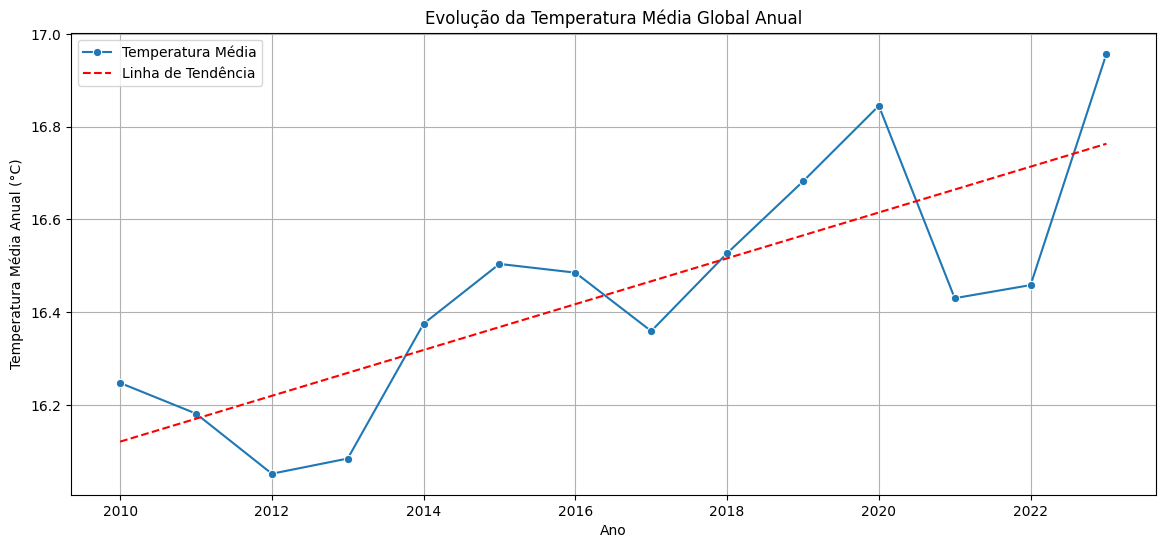

In [ ]:
# A temperatura global vem aumentando?

# média anual global da temperatura 2m (média entre todas as cidades)
temp_global = df_gold.groupby('ano')['temp_media'].mean().reset_index()

coef = np.polyfit(temp_global['ano'], temp_global['temp_media'], 1)
polynomial = np.poly1d(coef)
trendline = polynomial(temp_global['ano'])
plt.figure(figsize=(14,6))
sns.lineplot(data=temp_global, x='ano', y='temp_media', marker='o', label='Temperatura Média')
plt.plot(temp_global['ano'], trendline, color='red', linestyle='--', label='Linha de Tendência')
plt.title("Evolução da Temperatura Média Global Anual")
plt.xlabel("Ano")
plt.ylabel("Temperatura Média Anual (°C)")
plt.grid(True)
plt.legend()
plt.show()

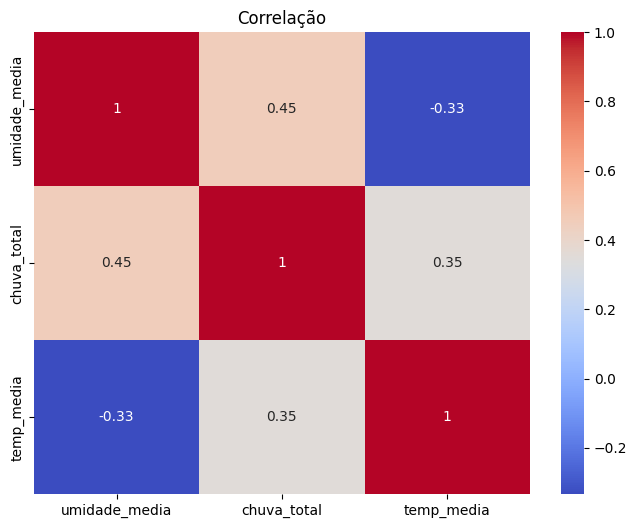

In [ ]:
# Existe alguma tendência quanto à umidade e nível de chuvas? Existe correlação entre eles?

plt.figure(figsize=(8,6))
plt.title('Correlação')
sns.heatmap(df_gold[['umidade_media', 'chuva_total', 'temp_media']].corr(), annot=True, cmap='coolwarm')
plt.show()

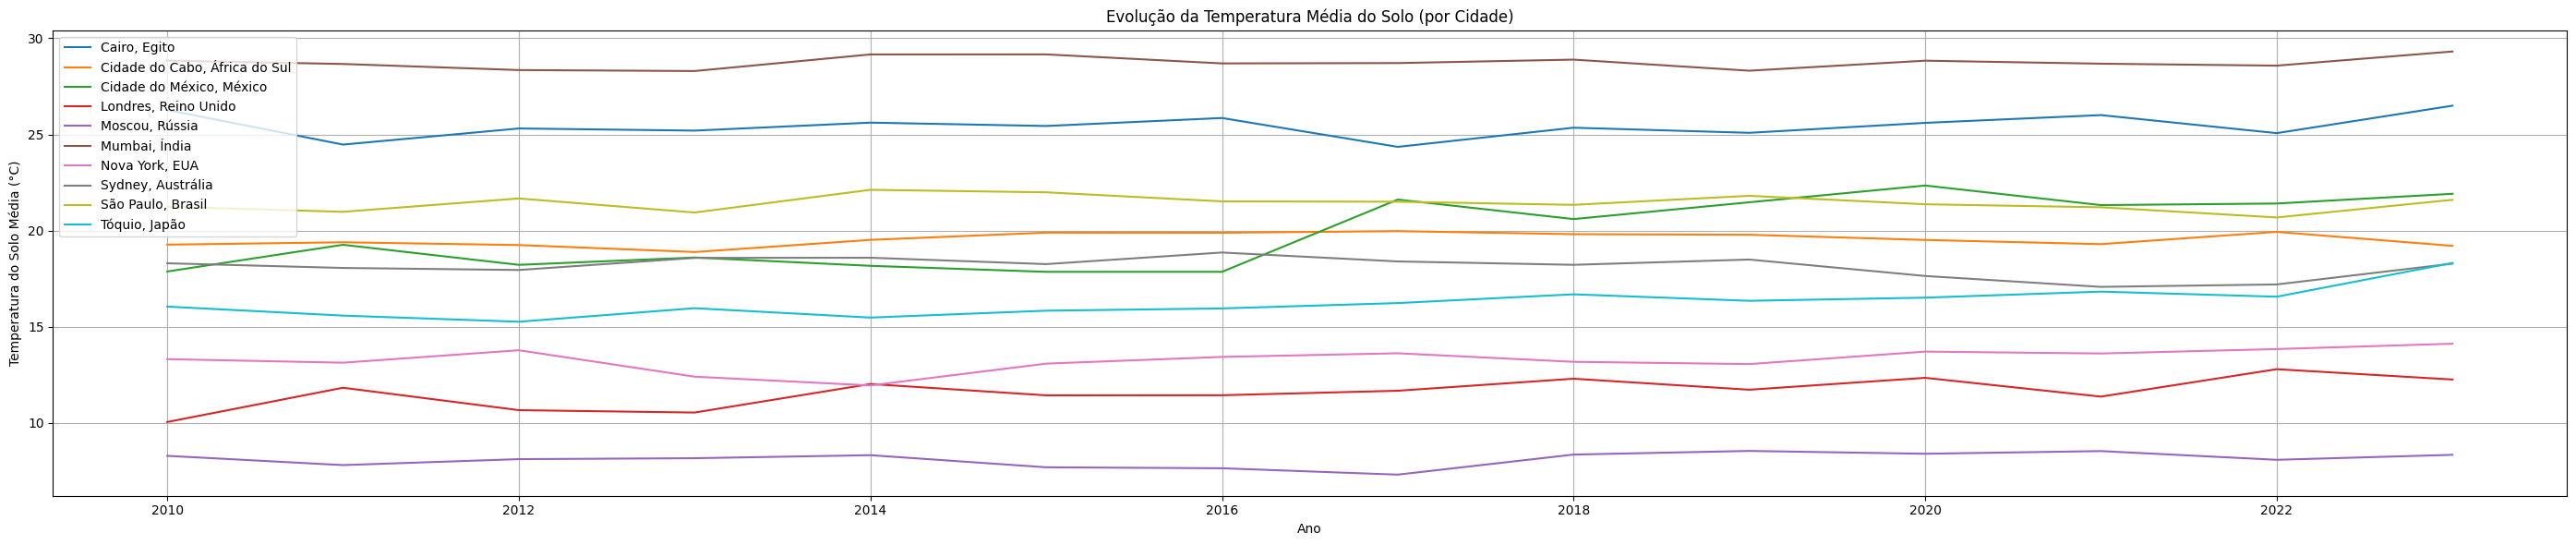

In [ ]:
# A temperatura do solo vem tendo alterações ou se mantém estável?

plt.figure(figsize=(28, 6))

for cidade in df_gold["cidade"].unique():
    dados_cidade = df_gold[df_gold["cidade"] == cidade]
    plt.plot(dados_cidade["ano"], dados_cidade["temp_solo_media"], label=cidade)
plt.title("Evolução da Temperatura Média do Solo (por Cidade)")
plt.xlabel("Ano")
plt.ylabel("Temperatura do Solo Média (°C)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()